In [5]:
import cv2
import time
import math
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from functools import reduce
from random import randint
import math
from itertools import combinations 
from scipy.stats import mode
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
from lxml import etree
import glob
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, date, time
import itertools

In [6]:
protoFile = "pytorch_toolkit/human_pose_estimation/pose_deploy_linevec.prototxt"
weightsFile = "pytorch_toolkit/human_pose_estimation/pose_iter_440000.caffemodel"
nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
# e.g for POSE_PAIR(1,2), the PAFs are located at indices (31,32) of output, Similarly, (1,5) -> (39,40) and so on.
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]



In [7]:
# Служебные функции - раскидывают  извлеченные точки по по объектам

def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)

    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    _,contours,_ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints
# Find valid connections between the different joints of a all persons present
def getValidPairs(output,frameWidth,frameHeight,detected_keypoints,keypoints_list):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # loop for every POSE_PAIR
    for k in range(len(mapIdx)):
        # A->B constitute a limb
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # Find the keypoints for the first and second limb
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # If keypoints for the joint-pair is detected
        # check every joint in candA with every joint in candB 
        # Calculate the distance vector between the two joints
        # Find the PAF values at a set of interpolated points between the joints
        # Use the above formula to compute a score to mark the connection valid
        
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):
                    # Find d_ij
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # Find p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # Find L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # Find E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)
                    
                    # Check if the connection is valid
                    # If the fraction of interpolated vectors aligned with PAF is higher then threshold -> Valid Pair  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Append the connection to the list
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # Append the detected connections to the global list
            valid_pairs.append(valid_pair)
        else: # If no keypoints are detected
            #print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    #print(valid_pairs)
    return valid_pairs, invalid_pairs
# This function creates a list of keypoints belonging to each person
# For each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs,keypoints_list):
    # the last number in each row is the overall score 
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])

            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break

                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # if find no partA in the subset, create a new subset
                elif not found and k < 17:
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # add the keypoint_scores for the two keypoints and the paf_score 
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints


def get_colour_distanse(color1,color2):

  color1_rgb = sRGBColor(color1[0],color1[1],color1[2]);

  color2_rgb = sRGBColor(color2[0],color2[1],color2[2]);

# Convert from RGB to Lab Color Space
  color1_lab = convert_color(color1_rgb, LabColor);

# Convert from RGB to Lab Color Space
  color2_lab = convert_color(color2_rgb, LabColor);

# Find the color difference
  delta_e = delta_e_cie2000(color1_lab, color2_lab);
  return delta_e

def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):

    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [8]:
# Проверяет боксы на пересечение
def overlap(rect1,rect2):
    x1min,y1min,x1max,y1max=rect1
    x2min,y2min,x2max,y2max=rect2
    hoverlaps = True
    voverlaps = True
    if ( x1min > x2max) or ( x1max<x2min ):
        hoverlaps = False
    if (y1max<y2min) or (y1min>y2max):
        voverlaps =True
   #print(hoverlaps , voverlaps)
    return hoverlaps 

({0: {'Neck': array([81.80173469, 63.57591837, 64.99892857]),
   'R-Sho': array([125.11790816, 111.19137755, 111.19510204]),
   'R-Elb': array([93.72826531, 65.60408163, 62.19882653]),
   'R-Wr': array([59.77244898, 39.30239796, 42.81882653]),
   'L-Sho': array([67.37653061, 47.38841837, 45.01372449]),
   'L-Elb': array([46.45122449, 30.09867347, 31.48892857]),
   'L-Wr': array([51.74632653, 35.81270408, 40.28377551]),
   'R-Hip': array([70.06428571, 45.60943878, 45.50602041]),
   'L-Hip': array([49.53612245, 36.16219388, 39.75831633])},
  1: {'Neck': array([113.12994898, 109.12938776, 100.74035714]),
   'R-Sho': array([120.33642857, 112.545     , 103.75709184]),
   'R-Elb': array([108.07535714, 103.81714286,  93.9480102 ]),
   'R-Wr': array([104.48454082, 103.5397449 ,  93.13979592]),
   'L-Sho': array([125.26408163, 123.86653061, 112.98265306]),
   'L-Elb': array([101.85841837,  96.59494898,  85.62454082]),
   'L-Wr': array([89.90908163, 79.48520408, 70.00795918]),
   'R-Hip': array(

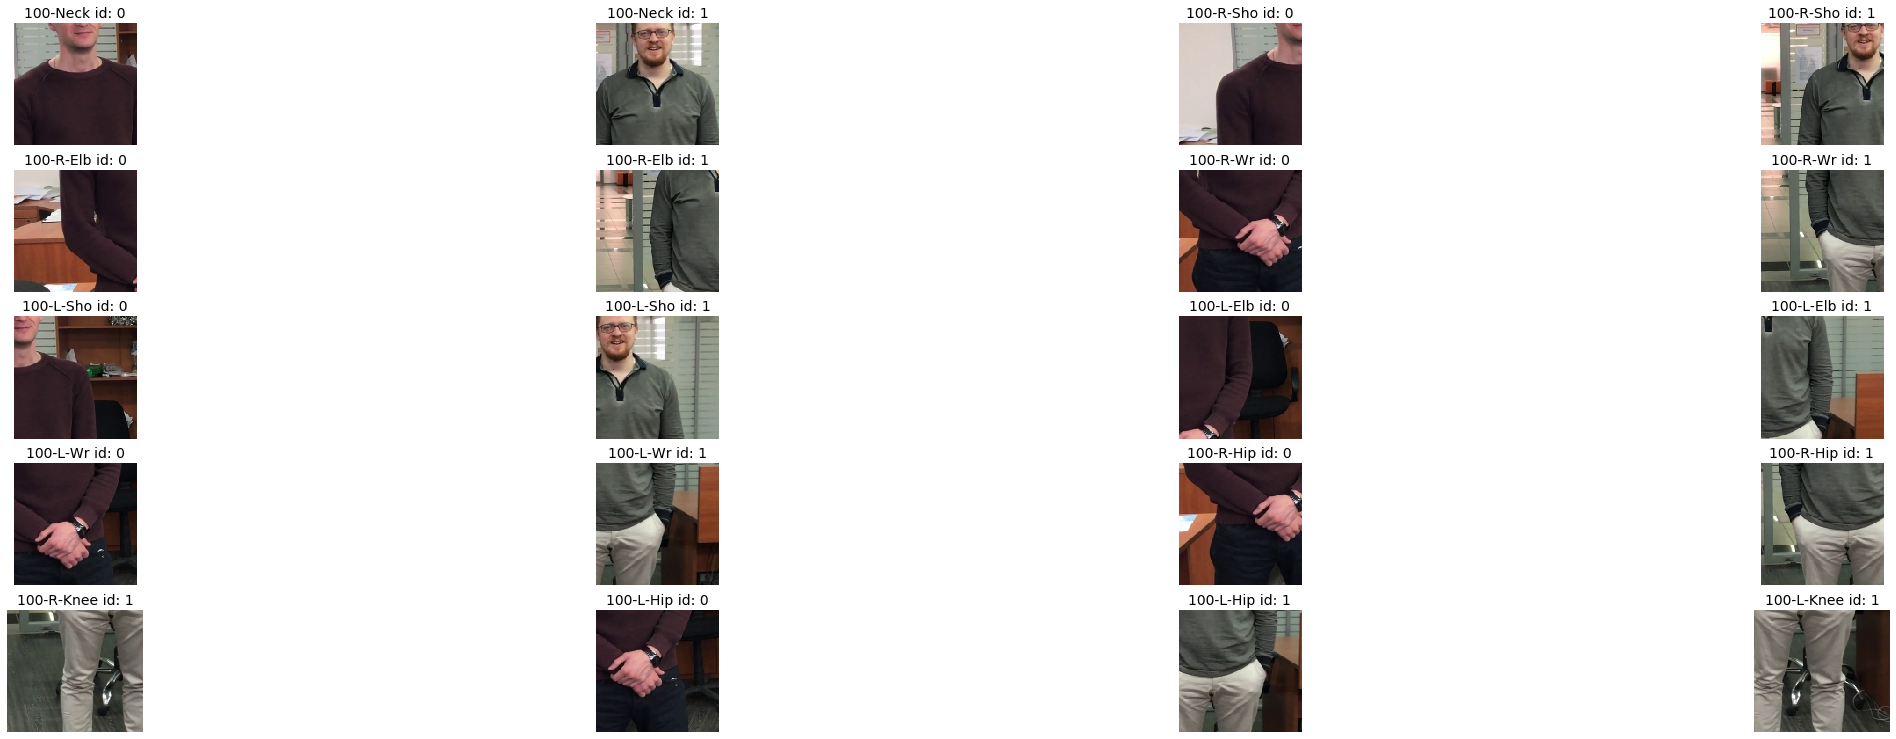

In [11]:
def get_avarrage_colour(img,sdvig=10,draw_pict=False ):
    
    image1 = cv2.imread(img)
    image1=cv2.resize(image1,(848,464))

    frameWidth = image1.shape[1]
    frameHeight = image1.shape[0]
    name=img[img.find('frame')+5:-4]

    ######################################################################################
    #Обучимся детктить
    net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

    # Fix the input Height and get the width according to the Aspect Ratio
    inHeight = 368
    inWidth = int((inHeight/frameHeight)*frameWidth)

    inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                            (0, 0, 0), swapRB=False, crop=False)

    net.setInput(inpBlob)
    output = net.forward()
    #######################################################################################

    detected_keypoints = []
    keypoints_list = np.zeros((0,3))
    keypoint_id = 0
    threshold = 0.1
    for part in range(nPoints):
        probMap = output[0,part,:,:]
        probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))

        keypoints = getKeypoints(probMap, threshold)

        keypoints_with_id = []
        for i in range(len(keypoints)):
            keypoints_with_id.append(keypoints[i] + (keypoint_id,))
            keypoints_list = np.vstack([keypoints_list, keypoints[i]])
            keypoint_id += 1

        detected_keypoints.append(keypoints_with_id) 
    valid_pairs, invalid_pairs = getValidPairs(output,frameWidth,frameHeight,detected_keypoints,keypoints_list)
    personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs,keypoints_list)
    frameClone = image1.copy()
    row=15
    col=4
    d=[]
    num=11
    

    
    avgs_colour={}
    keypoints={}
    if draw_pict:
        fig = plt.figure(figsize=(40, 40))
    ax = []
    indx=1
    keypointsMapping_new = [ 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee','L-Ank'] 

    
    #вытащим средние цвета для каждой точки
    
    for n in range(len(personwiseKeypoints)):
        #print(n,personwiseKeypoints[n].shape)
        avgs_colour[n]={}
        keypoints[n]={}
    for i in range(18):
        # исключим точки головы
        if keypointsMapping[i]  in keypointsMapping_new:
            
            for n in range(len(personwiseKeypoints)):
                index = int(personwiseKeypoints[n][i])

                if index==-1:
                    continue
                else:
                    # Зададим окрестность точки 
                    h=[np.int32(keypoints_list[index, 1]),np.int32(keypoints_list[index, 0])]
                    frameClone_temp = image1.copy()
                    myimg = frameClone_temp[h[0]-sdvig:h[0]+sdvig,h[1]-sdvig:h[1]+sdvig][:,:,[2,1,0]]
 
                    try:
                        # извлечем средний цвет
                        avg_color_per_row = np.mean(myimg, axis=0)
                        
                        avg_color = np.mean(avg_color_per_row, axis=0)
                    except:
                        pass
                      
                    avgs_colour[n][keypointsMapping[i]]=avg_color
                    keypoints[n][keypointsMapping[i]]=h
                    # Рисуем окрестность
                    if draw_pict:
                        ax.append( fig.add_subplot(row, col, indx)  )
                        ax[-1].set_title(name+'-'+keypointsMapping[i]+ ' id: '+str(n), fontsize=14)
                        plt.imshow(myimg)
                        plt.axis('off')
                        indx+=1

                        
   #################################################                     
    # Удалим детекции, где точки могут пересекаться
    rect_={}
    for key,value in keypoints.items():
        proc=0.1
        if len(value)>0 :   
            xmin=min([x[1] for x in value.values()])
            xmax=max([x[1] for x in value.values()])
            ymin=min([x[0] for x in value.values()])
            ymax=max([x[0] for x in value.values()])
            #rect_[key]=[xmin,ymin,xmax,ymax]
            #print('!!',rect_)
            rect_[key]=[int(xmin-proc*(xmax-xmin)),int(ymin),int(xmax+proc*(xmax-xmin)),int(ymax)]

    dots_te_delele=[]
    for id0,id1 in list(combinations(rect_.values(), 2)) :
        #Если персекаются
        if overlap(id0,id1): 

            dots_te_delele.append(id0)
            dots_te_delele.append(id1)
    rectangle_te_delele=[]

    for key,value in rect_.items():
        if value in dots_te_delele:
            rectangle_te_delele.append(key)
           
    for n in rectangle_te_delele:
        del avgs_colour[n]
        del keypoints[n]

     ################################################# 
            
                        
    #Удалим id где мало точек
   # try:
    #print(avgs_colour.keys())
    ids=avgs_colour.keys()
    ids_to_delete=[]
    for n in ids:

        #print(n,len(avgs_colour[n]) )
        if len(avgs_colour[n]) <6:
            ids_to_delete.append(n)
    for  id_ in ids_to_delete:     
            del avgs_colour[id_]
            del keypoints[id_]
     
    #      Средний цвет точки, кооординаты точки
    return avgs_colour,keypoints
get_avarrage_colour('pytorch_toolkit/di/frame100.jpg',sdvig=70,draw_pict=1 )

In [15]:
def compare_point(frame0,frame1, threshold=60):
    avg_colours0, dots0=frame0
    avg_colours1, dots1=frame1
    
    try:    
        results={}
        result_with_distance={}
       
        # Достанем общие точки для сопоставления
        common_points=reduce(set.intersection, (set(val) for val in avg_colours0.values()))&reduce(set.intersection, (set(val) for val in avg_colours1.values()))
        # Достанем все Id с обоих фремов
        all_person=set([int(val) for val in list(avg_colours1.keys())]).union(set([int(val) for val in list(avg_colours0.keys())]) )

        for n in all_person: 
            results[n]={}
            result_with_distance[n]={}

        distances=np.array([[0,0,0,0]])

        # Для каждого id на первом фреме avg_colours1.values()
        for id_0_frame in set([int(val) for val in list(avg_colours0.keys())]):
            # Для каждого id на втором фреме
            for id_1_frame in set([int(val) for val in list(avg_colours1.keys())]):
                # Для каждой точки из всех точек
                for point in common_points:                
                    # Найдем расстояние межуд цветами
                    dist=get_colour_distanse(avg_colours1[id_1_frame][point],avg_colours0[id_0_frame][point])
                    #print(dist)
                    # Если расстояние между цветам меньше threshold добавим в напушный массив
                    if dist< threshold:
                         distances=np.append(distances,[[int(dist),id_1_frame,id_0_frame,point]], axis = 0)

        
        # Немного напушной магии- достанем  точки первого фрейма ближайшую точку второго фрейма
        for id_1_frame in set(distances[:,1]):
            k=distances[np.where( distances[:,1] == id_1_frame )]
            for point in  set(k[:,3]):
                b=k[np.where( k[:,3] == point )]
                c=b[b[:,0].argsort()][:1]
                results[int(c[0][1])][point]=int(c[0][2])
                
        points_=list(results.keys())
        for point in points_:
            if len(results[point])<5:
                del results[point]
    
    
    except:
        pass    
    avgs_new={}
    keypoints_new={}
   
    choices=[]
    try:
        count_id=max(set([int(val) for val in list(avg_colours0.keys())])) +1
    except:
        pass
 
    # Удалим такие точки, где результат голосования совпадает, оставив те , шгде голосов большще
    id_to_del=[]
    for id0,id1 in list(combinations(results.keys(), 2)) :
        if mode(list(results[id0].values()))[0][0]==mode(list(results[id1].values()))[0][0]:

            if list(results[id0].values()).count(mode(list(results[id0].values()))[0][0])> list(results[id1].values()).count(mode(list(results[id1].values()))[0][0]):
              
                id_to_del.append(id1)
            else:
                 id_to_del.append(id0)

    for _id_ in id_to_del: 
        del results[_id_ ]
    

    
    # Проведем голосование присвоиив id нелевого фрейма id-никам первого
    for person in set([int(val) for val in list(results.keys())]):
        if len(results[person].values())>2:
            choice=mode(list(results[person].values()))[0][0]
 
            keypoints_new[choice]=dots1[person]
            avgs_new[choice]=avg_colours1[person]
            choices.append(person)
    # Если для точек второго фрейма не налось достаточно голосов-считаем, что это новый объект 
    for person in avg_colours1.keys():
        if person not in choices:

            keypoints_new[count_id]=dots1[person]
            avgs_new[count_id]=avg_colours1[person]
            count_id+=1

        count_id+=1
      #      Средний цвет точки, кооординаты точкии  
    return  avgs_new,keypoints_new
compare_point(get_avarrage_colour('pytorch_toolkit/ni/frame112.jpg',sdvig=5),get_avarrage_colour('pytorch_toolkit/ni/frame119.jpg',sdvig=5))

({0: {'Neck': array([45.74, 49.84, 53.04]),
   'R-Sho': array([67.76, 65.8 , 58.13]),
   'R-Elb': array([46.7 , 37.22, 28.64]),
   'R-Wr': array([64.13, 48.79, 41.16]),
   'L-Sho': array([58.21, 64.38, 66.16]),
   'L-Elb': array([54.48, 49.53, 46.45]),
   'L-Wr': array([69.22, 54.74, 58.64]),
   'R-Hip': array([47.67, 53.46, 51.29]),
   'R-Knee': array([23.69, 31.01, 34.57]),
   'L-Hip': array([52.89, 57.8 , 60.8 ]),
   'L-Knee': array([27.7 , 34.7 , 40.94])},
  1: {'Neck': array([110.47,  92.76,  80.14]),
   'R-Sho': array([78.21, 64.6 , 55.43]),
   'L-Sho': array([108.78,  90.21,  77.02]),
   'L-Elb': array([43.06, 35.82, 31.6 ]),
   'L-Wr': array([88.13, 65.35, 54.  ]),
   'R-Hip': array([32.96, 26.52, 27.02]),
   'R-Knee': array([64.82, 75.27, 84.82]),
   'R-Ank': array([80.48, 78.22, 70.73]),
   'L-Hip': array([25.52, 23.57, 23.9 ]),
   'L-Knee': array([35.11, 33.74, 32.86]),
   'L-Ank': array([34.03, 38.45, 36.95])}},
 {0: {'Neck': [236, 338],
   'R-Sho': [236, 297],
   'R-Elb': 

In [16]:
def mem(frame0,frame1, threshold):
    avgs0,dots0=frame0
    avgs1,dots1=frame1
    avgs={}
    keypoints={}
    compare=compare_point(frame0,frame1, threshold)

    
    
    all_person=set([int(val) for val in list( avgs0.keys())]).union(set([int(val) for val in list(compare[0].keys())]) )

    for person in all_person:
        if person in compare[0].keys():
            
            avgs[person]=compare[0][person]
            keypoints[person]=compare[1][person]
            
        # Смысл здесь - мы добавляем в память дескритор -среднйи цвет в окрестности
        #из предыдущего фрейма, если он не встречается в новом    
        else:   
            avgs[person]=avgs0[person]
            

    return avgs,keypoints

In [33]:
def get_memory(path,skip_frame=0,sdvig=15, threshold=60):
    n=8
    # Загрузим файлы из папки
    frames_to_load=glob.glob(path+'*.jpg')
    
    # Отсортируем 
    frames_to_load=[str(path)+'frame'+str(x)+'.jpg' for x in sorted([int(x[len(path)+5:-4]) for x in (frames_to_load)])]
    frames_to_load=frames_to_load[:]
    
    # Пропускает фреймы с каким то шагом
    if skip_frame>0:
        frames_to_load=frames_to_load[::skip_frame]
     
    frames=[]
    all_frames={}
    num=0
    
    for fra in frames_to_load:
       
        if num%10==0:
            print(str(round(num/len(frames_to_load)*100))+' %')
        #print(fra,'<====')
        num+=1
        frames.append(fra[19:-4])
        # Получим средние цвета для каждого фрейма
        locals()['frame'+fra[24:-4]]=get_avarrage_colour(path+"frame"+fra[24:-4]+".jpg",sdvig,False)
        all_frames['frame'+str(fra[24:-4])]=eval('frame'+str(fra[24:-4]))
    #Инициализируем память
    memory_dot={}
    a=mem(eval(frames[0]),eval(frames[1]), threshold)
   
    _,memory_dot[frames[0]]=eval(frames[0])
    _,memory_dot[frames[1]]=a
    # Итеративно наполним память 
    for x in range(2,len(frames)):
        #print('YYYYYYYYYYY',x)
        #print(frames[x])
        a=mem(a,eval(frames[x]), threshold)
        _,memory_dot[frames[x]]=a
        #globals()['mem_qt'+str(frames_to_load[x][-8:-4])] =a
        result=memory_dot
        # Дропаут
        id_to_delete=[]
        if (x+1)%50 ==0 and x>20:
            
            for key,value in result.items():
                #print('22',value)
                for key_,value_ in value.items():
                    
                    id_to_delete.append(key_)
            #print('d_to_delete',id_to_delete)
            id_to_delete_=[]
            for  x in set(id_to_delete) :
                if  (np.array(id_to_delete) == x).sum()<8:
                   
                    id_to_delete_.append(x)
            
            if len(id_to_delete_)  >0:
              
                del a[0][id_to_delete_[0]]
  
            result_new={}
            for key,values in result.items():
             
                result_new[key]={}
                for key_,value_ in values.items():
                   
                    if key_ not in id_to_delete_:
                        result_new[key][key_]=value_
                        
            memory_dot=   result_new           
           
    # Приведем названия id  к последовательным
    ids_to_rename=[]
    for frame_temp in memory_dot.keys():
        for id_temp in memory_dot[frame_temp].keys():
            ids_to_rename.append(id_temp)
    
    ids_to_rename=list(set(ids_to_rename))
    ids_for_rename=[x for x in range(0,1000)]
   #
    memory_dot_rename={}
    for frame_temp in memory_dot.keys():
        memory_dot_rename[frame_temp]={}
        for id_temp,value_temp in memory_dot[frame_temp].items():
            memory_dot_rename[frame_temp][ids_for_rename[ids_to_rename.index(id_temp)]]=value_temp
            
            
    
    return memory_dot_rename
get_memory(path='pytorch_toolkit/di/',skip_frame=0,sdvig=15, threshold=60)

0 %


{'frame100': {0: {'Neck': [207, 146],
   'R-Sho': [216, 85],
   'R-Elb': [317, 76],
   'R-Wr': [368, 147],
   'L-Sho': [206, 215],
   'L-Elb': [296, 226],
   'L-Wr': [357, 187],
   'R-Hip': [388, 127],
   'L-Hip': [378, 197]},
  1: {'Neck': [177, 549],
   'R-Sho': [185, 498],
   'R-Elb': [248, 479],
   'R-Wr': [307, 489],
   'L-Sho': [177, 591],
   'L-Elb': [256, 610],
   'L-Wr': [316, 601],
   'R-Hip': [317, 519],
   'R-Knee': [408, 510],
   'L-Hip': [317, 580],
   'L-Knee': [408, 570]}},
 'frame101': {0: {'Neck': [207, 146],
   'R-Sho': [217, 85],
   'R-Elb': [317, 76],
   'R-Wr': [368, 147],
   'L-Sho': [206, 215],
   'L-Elb': [296, 226],
   'L-Wr': [357, 187],
   'R-Hip': [388, 127],
   'L-Hip': [378, 197]},
  1: {'Neck': [177, 549],
   'R-Sho': [185, 498],
   'R-Elb': [247, 480],
   'R-Wr': [307, 489],
   'L-Sho': [177, 591],
   'L-Elb': [256, 610],
   'L-Wr': [317, 601],
   'R-Hip': [317, 519],
   'R-Knee': [408, 510],
   'L-Hip': [317, 580],
   'L-Knee': [408, 570]}}}

In [ ]:
# Фунция проверяет входит ли облако точек в бокс
def CheckPoint(rectangle, dot) :
    cnt=0
    for key,dots in dot.items():
        x,y=dots[1],dots[0]
        x1, y1, x2, y2=   rectangle[0],rectangle[1],rectangle[2],rectangle[3]

        if (x > x1 and x < x2 and 
            y > y1 and y < y2) :
            continue
        else:
            cnt+=1
         
    if cnt <3:
        return True
    else:
        return False

In [34]:
# Функция загружает разметку
def add_or_append(dictionary, key, value):
    if key not in dictionary:
        dictionary[key] = []
    dictionary[key].append(value)
def parseXML(xmlFile):
    """
    Парсинг XML
    """
    dict_anno={} 
    with open(xmlFile) as fobj:
        xml = fobj.read()
    
    root = etree.fromstring(xml)
   
    for x in root:
        if x.tag=='object':
            #print(len(x))
            for y in x:
                if y.tag=='name':
                   
                    id_=int(y.text)
                if y.tag=='polygon': 
                    
                    for z in y:
                        if z.tag=='pt':
                            
                            add_or_append(dict_anno,id_, int(z[0].text))
                            add_or_append(dict_anno,id_, int(z[1].text))
                            
    return dict_anno
parseXML('pytorch_toolkit/testdi/frame100.xml')

{0: [89, 198, 547, 198, 547, 1079, 89, 1079],
 1: [1041, 200, 1420, 200, 1420, 1079, 1041, 1079]}

In [ ]:
# Функция рисует видео
def create_video(in_folder, out_video,sdvig, threshold):
    img_array = []
    frames_to_convert=glob.glob('out/*.jpg')
    frames_to_convert=[str(in_folder)+'frame'+str(x)+'.jpg' for x in sorted([int(x[len(in_folder)+5:-4]) for x in (frames_to_convert)])]
    for filename in frames_to_convert:
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        
        img_array.append(img)


    out = cv2.VideoWriter(out_video+datetime.now().strftime("%Y-%m-%d-%H.%M.%S")+'_sdvig'+str(sdvig)+'_threshold'+str(threshold)+'_project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()


In [ ]:
# Функция формирует кадры для видео

def make_video(path,mark_up=False,path_mark_up='pytorch_toolkit/test/',make_video=True,skip_frame=0,sdvig=15, threshold=60):
    frames_to_draw=get_memory(path,skip_frame,sdvig, threshold)
    
    colours_of_dots=[[0, 0, 255], [124, 252, 0], [124, 252, 200],[124, 0, 200], [124, 252, 200],[124, 0, 200], [124, 252, 200],[124, 0, 200]]
    print('done - GET DOTS')
    
    tracker_mem=frames_to_draw
    mark_up_mem={}
    if mark_up:
        

        for frame,value_frame in frames_to_draw.items():
            print(frame)
            
            img=path+frame+'.jpg'
            image1 = cv2.imread(img)
            image1=cv2.resize(image1,(848,464))
            print(image1.shape)
            frameClone = image1.copy()
            for key,value in value_frame.items():

                b=value[list(value.keys())[0]]

                for key_,value_ in value.items():

                    cv2.circle(frameClone, tuple([value_[1],value_[0]]), 3, colours_of_dots[key], -1, cv2.LINE_AA)
                    cv2.putText(frameClone,'tr_id-'+str(key), (b[1], b[0]), cv2.FONT_ITALIC, 1.0, colours_of_dots[key],thickness = 3)

            mark_up_mem[frame]={}
            load_markup=parseXML(path_mark_up+frame+'.xml')
            print(load_markup)
            #print(load_markup,'fffffffffffff')
            for  markup_id in load_markup:
                #print(markup_id)
                c=load_markup[markup_id][:2]
               # print('22222',c)
                rectang_dots=np.array(load_markup[markup_id]).reshape(-1,1,2)
                print('_____')
                print(rectang_dots)
                print('_____')
                cv2.polylines(frameClone,[rectang_dots],True,colours_of_dots[markup_id],thickness = 3,lineType =2)
                cv2.putText(frameClone,'m_id-'+str(markup_id), (c[0], c[1]-10), cv2.FONT_ITALIC, 1.0, colours_of_dots[markup_id],thickness = 3)
                mark_up_mem[frame][markup_id]=[rectang_dots]
        
            cv2.imwrite("out/"+frame+".jpg", frameClone)
 
        
        tp=0
        fp=0
        all_detection=0
        all_ground_truth=0
        fn=0
        tn=0

        for x in tracker_mem.keys():
            for id_tr in tracker_mem[x].keys():
                if id_tr in mark_up_mem[x].keys():
                    value=mark_up_mem[x][id_tr]
                    rect=[value[0][0][0][0],value[0][0][0][1],value[0][2][0][0],value[0][2][0][1]]
                    if CheckPoint(rect,tracker_mem[x][id_tr]):
                        #print('трекрер угадал класс')
                        tp+=1
                    
                all_detection+=1
            for id_mark in mark_up_mem[x].keys():
                all_ground_truth+=1
                
        fn=all_ground_truth-tp
        fp=all_detection-tp

        recall=tp/all_ground_truth
        precision=tp/all_detection
        
        
        print('all_detection',all_detection)
        print('all_ground_truth',all_ground_truth)
        print('tp',tp) 
        print('fp',fp)
        print('fn',fn)
        
        print('precision', precision)
        print('recall',recall)
        k=int(str(list(frames_to_draw.keys())[-1])[5:])
        print(k)
        for h in range(k+1,k+100):
            img = np.zeros( (464, 848,  3), dtype = "uint8") 
        cv2.putText(img,'precision-'+str(precision), (130, 150), cv2.FONT_ITALIC, 1.0, [255, 255, 255],thickness = 4)
            cv2.putText(img,'recall-'+str(recall), (130, 200), cv2.FONT_ITALIC, 1.0, [255, 255, 255],thickness = 4)
            #cv2.putText(img,'accuracy-'+str(accuracy), (130, 250), cv2.FONT_ITALIC, 1.0, [255, 255, 255],thickness = 4)
            cv2.imwrite("out/"+'frame'+str(h)+".jpg",  img)


    else:
        for frame,value_frame in frames_to_draw.items():
     
            img=path+frame+'.jpg'
            image1 = cv2.imread(img)
            image1=cv2.resize(image1,(848,464))
            frameClone = image1.copy()
            try:
                for key,value in value_frame.items():
                    b=value[list(value.keys())[0]]
                    for key_,value_ in value.items():

                        cv2.circle(frameClone, tuple([value_[1],value_[0]]), 3, colours_of_dots[key], -1, cv2.LINE_AA)
                        cv2.putText(frameClone,'->'+str(key), (b[1], b[0]), cv2.FONT_ITALIC, 1.0, colours_of_dots[key],thickness = 3)
                plt.imshow(frameClone[:,:,[2,1,0]])
                cv2.imwrite("out/"+frame+".jpg", frameClone)
            except:
                pass
    if  make_video:
        print('Make video')
        create_video('out/','out_video/',sdvig, threshold)
#make_video('pytorch_toolkit/di/',mark_up=1,skip_frame=0,make_video=1,sdvig=7,path_mark_up='pytorch_toolkit/testdi/',threshold=50)